In [2]:
import os
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio.windows import Window
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch

In [4]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def transform_crs(dst_crs, resolution):
    for year in [2010,2015]:
        path_bio = f"../data/raw/biomass/amazonia/{resolution}m/" + f"mapbiomas-brazil-collection-70-amazonia-{year}.tif"
        with rasterio.open(path_bio) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(f"../data/interim/biomass/amazonia/{resolution}m/" + f"biomass_{year}.tif", 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                
# function to load biomass data
def load_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/interim/biomass/amazonia/{resolution}m/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    return bio_data, out_meta

# function to transform labels to 1=forest, 2=non_forest, 0=unknown
def transform_to_labels(bio_data):
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
                22:3,23:3,24:3,30:3,25:3, # urban
                26:4,33:4,31:4, # water
                27:255,0:255} # unobserved
    bio_data_new = np.zeros_like(bio_data)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return bio_data_new

# function to load biomass data
def load_processed_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/processed/biomass/amazonia/{resolution}m/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    return bio_data, out_meta

def preprocess_data(dst_crs, resolution):
    transform_crs(dst_crs, resolution)

    all_years = [2010,2015]

    bio_data = []
    out_meta = []
    for year in all_years:
        bio_data_year, out_meta_year = load_biomass_data(year, None)
        bio_data_year = transform_to_labels(bio_data_year)
        bio_data.append(bio_data_year)
        out_meta.append(out_meta_year)

    '''
    # replace unobserved with previously observed
    for i in np.arange(1, len(bio_data)):
        previously_observed = (bio_data[i] == 255) & (bio_data[i-1] != 255)
        bio_data[i][previously_observed] = bio_data[i-1][previously_observed]
    '''

    # save
    for i, year in enumerate(all_years):
        with rasterio.open(f"../data/processed/biomass/amazonia/{resolution}m/" + f"biomass_{year}.tif", "w", **out_meta[i]) as dest:
            dest.write(np.expand_dims(bio_data[i], axis=0))

In [78]:
resolution = 250
dst_crs = 'EPSG:6933'
preprocess_data(dst_crs, resolution)

# Define raster parameters

In [42]:
px_resolution = 250 # calculate from area
output_ha = 10000
output_px = np.sqrt(output_ha*10000)/px_resolution
input_px= 10 * output_px
delta = input_px - output_px

print(output_px)
print(input_px)

40.0
400.0


# Load bio data

In [43]:
# function to load biomass data
def load_processed_biomass_data(year, shape, resolution=250, delta=None):
    path_bio = f"../data/processed/biomass/amazonia/{resolution}m/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    bio_data = torch.from_numpy(bio_data)
    if delta is not None:
        diff_x = int((bio_data.shape[1]%delta)/2 + delta)
        diff_y = int((bio_data.shape[0]%delta)/2 + delta)
        bio_data = torch.nn.functional.pad(bio_data, (diff_y, diff_y, diff_x, diff_x), value=255)
    return bio_data, out_meta

In [44]:
year = 2010
bio_data_2010, bio_data_meta = load_processed_biomass_data(year, None, resolution=250, delta=delta)

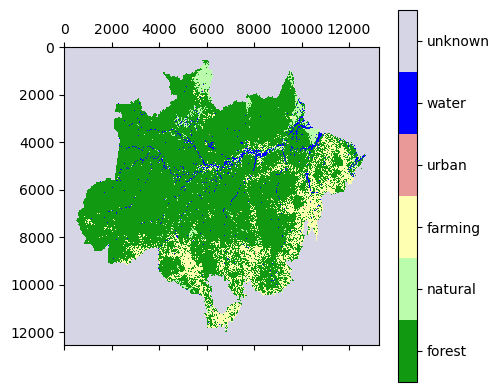

In [45]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data_2010,cmap=cmap,vmin = -.5, vmax = 5.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

# Load transition data

In [46]:
def load_processed_transition_data(year_start, year_end, shape=None, resolution=250, delta=None):
    path_bio = f"../data/processed/biomass/amazonia/{resolution}m/" 
    path_bio = path_bio + f"transition_{year_start}_{year_end}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255
            transition_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            transition_data = transition_data.squeeze().astype(bool)
            out_meta.update({"driver": "GTiff",
                 "height": transition_data.shape[0],
                 "width": transition_data.shape[1],
                 "transform": out_transform})
        else:
            transition_data = src.read(1).astype(bool)
    transition_data = torch.from_numpy(transition_data)
    if delta is not None:
        diff_x = int((transition_data.shape[1]%delta)/2 + delta)
        diff_y = int((transition_data.shape[0]%delta)/2 + delta)
        transition_data = torch.nn.functional.pad(transition_data, (diff_y, diff_y, diff_x, diff_x), value=False)
    return transition_data, out_meta

In [47]:
transition_2005_2010, _ = load_processed_transition_data(2005, 2010, resolution=250, delta=delta)
transition_2010_2015, _ = load_processed_transition_data(2010, 2015, resolution=250, delta=delta)
transition_2015_2020, _ = load_processed_transition_data(2015, 2020, resolution=250, delta=delta)

# Compute raster

In [48]:
height = bio_data_2010.shape[0]
width = bio_data_2010.shape[1]

x = np.arange(0.5 * delta, width - 0.5 * delta, delta)
y = np.arange(0.5 * delta, height - 0.5 * delta, delta)
xv, yv = np.meshgrid(x, y)

bbox = []
for x, y in zip(xv.flatten(), yv.flatten()):
    window_bio = bio_data_2010[int(y-delta/2):int(y+delta/2), int(x-delta/2):int(x+delta/2)]
    forest_cover = np.count_nonzero(window_bio == 0)/delta**2
    empty_cover = np.count_nonzero(window_bio == 255)/delta**2

    # filter clusters that dont have any forest or are mostly empty
    if (forest_cover >= 0) & (empty_cover < 1):
        window_transition_prior = transition_2005_2010[int(y-delta/2):int(y+delta/2), int(x-delta/2):int(x+delta/2)]
        transition_prior = torch.sum(window_transition_prior)/delta**2
        bbox.append((x,y,transition_prior))

xv, yv, transition_prior = zip(*bbox)

nr_bins = 6
bins = np.linspace(0,np.max(transition_prior),nr_bins)
transition_prior_bin = np.digitize(transition_prior, bins, right=True)

data_grid = np.vstack([xv, yv, transition_prior, transition_prior_bin]).T
train_data, val_data = train_test_split(data_grid, test_size=0.1, random_state=42, stratify=data_grid[:,-1])

delete_indices = []
for point in val_data:
    for x_sign, y_sign in zip([+1,+1,+1,0,0,-1,-1,-1], [+1,0,-1,+1,-1,+1,0,-1]):
        indices = np.where((train_data[:,0] == point[0] - delta * x_sign) & (train_data[:,1] == point[1] - delta * y_sign))[0]
        if len(indices) > 0:
            delete_indices.append(indices[0])

dropped_data = train_data[np.unique(delete_indices)]
train_data = np.delete(train_data, delete_indices, axis=0)

In [49]:
unique_ppp = int(delta / output_px)**2
print("Dropped data: ", dropped_data.shape[0], dropped_data.shape[0]/len(transition_prior))
print("Train data: ", train_data.shape[0], train_data.shape[0]/len(transition_prior), train_data.shape[0]/(train_data.shape[0]+val_data.shape[0]), train_data.shape[0]*unique_ppp)
print("Val data: ", val_data.shape[0], val_data.shape[0]/len(transition_prior), val_data.shape[0]/(train_data.shape[0]+val_data.shape[0]), val_data.shape[0]*unique_ppp)

Dropped data:  339 0.5159817351598174
Train data:  252 0.3835616438356164 0.7924528301886793 20412
Val data:  66 0.1004566210045662 0.20754716981132076 5346


[454.  65.  22.   5.   4.]
107


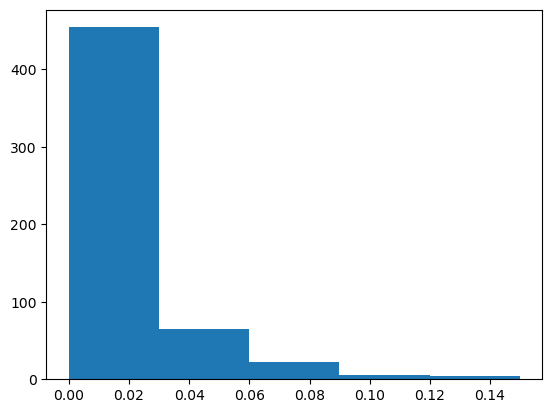

In [50]:
nr_bins = 6
transition_prior = np.array(transition_prior)
bins = np.linspace(0,np.max(transition_prior),nr_bins)
transition_prior_bin = np.digitize(transition_prior, bins, right=True)
bin_box = plt.hist(transition_prior[transition_prior > 0], bins=bins)
print(bin_box[0])
print(np.count_nonzero(transition_prior_bin == 0))
plt.show()

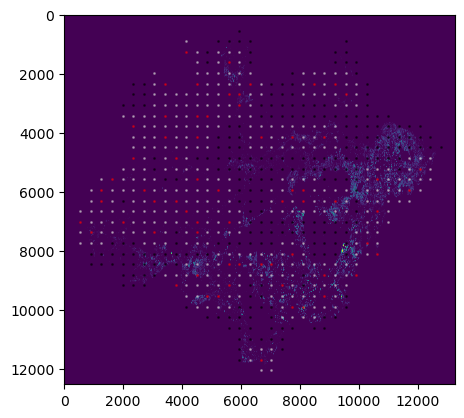

In [51]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
# mat = plt.matshow(bio_data_2010,cmap=cmap,vmin = -.5, vmax = 5.5)
plt.imshow(transition_2005_2010, alpha=1)
plt.scatter(val_data[:,0], val_data[:,1], s=1, c='red', alpha=0.5)
plt.scatter(train_data[:,0], train_data[:,1], s=1, c='k', alpha=0.5)
plt.scatter(dropped_data[:,0], dropped_data[:,1], s=1, c='lightgrey', alpha=0.5)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

# Fine grain raster

In [52]:
train_data[:5]

array([[9.54000000e+03, 5.22000000e+03, 7.07638860e-02, 3.00000000e+00],
       [5.22000000e+03, 9.00000000e+02, 0.00000000e+00, 0.00000000e+00],
       [7.02000000e+03, 4.86000000e+03, 6.26543211e-03, 1.00000000e+00],
       [5.94000000e+03, 7.74000000e+03, 3.85802472e-04, 1.00000000e+00],
       [3.42000000e+03, 8.10000000e+03, 2.18672846e-02, 1.00000000e+00]])

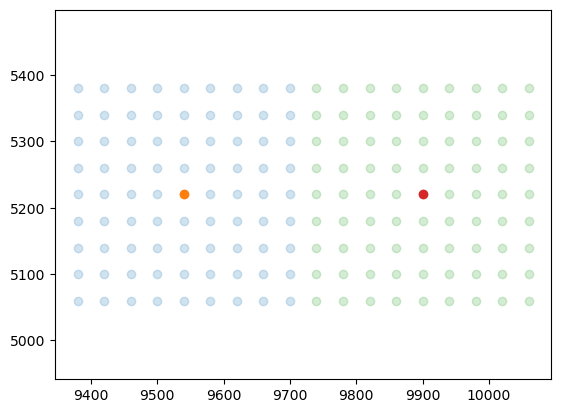

In [53]:
train_data_cluster = train_data[0]

x_cluster = train_data_cluster[0]
y_cluster = train_data_cluster[1]
x = np.arange(int(x_cluster-delta/2+output_px/2), int(x_cluster+delta/2+output_px/2), output_px)
y = np.arange(int(y_cluster-delta/2+output_px/2), int(y_cluster+delta/2+output_px/2), output_px)
xv, yv = np.meshgrid(x, y)

x_cluster_1 = x_cluster + delta
y_cluster_1 = y_cluster
x = np.arange(int(x_cluster_1-delta/2+output_px/2), int(x_cluster_1+delta/2+output_px/2), output_px)
y = np.arange(int(y_cluster_1-delta/2+output_px/2), int(y_cluster_1+delta/2+output_px/2), output_px)
xv_1, yv_1 = np.meshgrid(x, y)

plt.scatter(xv,yv, alpha=0.2)
plt.scatter(x_cluster, y_cluster)
plt.scatter(xv_1,yv_1, alpha=0.2)
plt.scatter(x_cluster_1, y_cluster_1)
plt.axis("equal")
plt.show()

In [54]:
# clusters -> filtered when empty, no forest -> no deforestation possible
# points -> output: filter when empty > 0.8, no-forest | input: filter when empty > 0.8, prior_loss <= 0.0
def filter_empty_points(x,y,bio_data, input_px, output_px):
    window_bio_out = bio_data[int(y-output_px/2):int(y+output_px/2), int(x-output_px/2):int(x+output_px/2)]
    forest_cover_out = np.count_nonzero(window_bio_out == 0)/output_px**2
    empty_cover_out = np.count_nonzero(window_bio_out == 255)/output_px**2
    if (forest_cover_out > 0) & (empty_cover_out < 0.8):
        window_bio_in = bio_data[int(y-input_px/2):int(y+input_px/2), int(x-input_px/2):int(x+input_px/2)]
        empty_cover_in = np.count_nonzero(window_bio_in == 255)/input_px**2
        if empty_cover_in < 0.8:
            return False
    return True

def filter_non_transitioning_points(x,y,transition_prior, input_px):
    window_transition_prior_in = transition_prior[int(y-input_px/2):int(y+input_px/2), int(x-input_px/2):int(x+input_px/2)]
    transition_prior_in = torch.sum(window_transition_prior_in)/input_px**2
    if transition_prior_in > 0:
        return False
    return True

def get_points_from_cluster(train_data, bio_data, transition_prior, transition_future):
    train_data_points = []
    filtered_empty_px = 0
    filtered_non_transitioning_px = 0
    included_px = 0
    for train_data_cluster in train_data:
        x_cluster = train_data_cluster[0]
        y_cluster = train_data_cluster[1]
        x = np.arange(int(x_cluster-delta/2+output_px/2), int(x_cluster+delta/2+output_px/2), output_px)
        y = np.arange(int(y_cluster-delta/2+output_px/2), int(y_cluster+delta/2+output_px/2), output_px)
        xv, yv = np.meshgrid(x, y)

        for x, y in zip(xv.flatten(), yv.flatten()):

            window_transition_future = transition_future[int(y-output_px/2):int(y+output_px/2), int(x-output_px/2):int(x+output_px/2)]
            transition_future_px = torch.sum(window_transition_future).item()

            if filter_empty_points(x,y,bio_data, input_px, output_px):
                filtered_empty_px += transition_future_px
            elif filter_non_transitioning_points(x,y,transition_prior, input_px):
                filtered_non_transitioning_px += transition_future_px
            else:
                train_data_points.append((x,y,x_cluster,y_cluster))
                included_px += transition_future_px
    return np.array(train_data_points), (filtered_empty_px, filtered_non_transitioning_px, included_px)

In [55]:
train_data_points, test_filter_metrics = get_points_from_cluster(train_data, bio_data_2010, transition_2005_2010, transition_2010_2015)
val_data_points, val_filter_metrics = get_points_from_cluster(val_data, bio_data_2010, transition_2005_2010, transition_2010_2015)
dropped_data_points, dropped_filter_metrics = get_points_from_cluster(dropped_data, bio_data_2010, transition_2005_2010, transition_2010_2015)

In [56]:
filter_metrics = np.array([test_filter_metrics,val_filter_metrics,dropped_filter_metrics])
print(np.sum(filter_metrics), torch.sum(transition_2010_2015).item())
print("Disregarded Loss - empty input: {:.2f}%".format(np.sum(filter_metrics[:,0])/np.sum(filter_metrics) * 100))
print("Disregarded Loss - non transitioning: {:.4f}%".format(np.sum(filter_metrics[:,1])/np.sum(filter_metrics)*100))
print("train_data: {:.0f} | {:.2f}%".format(len(train_data_points), len(train_data_points)/(len(train_data_points)+len(val_data_points))))
print("val_data: {:.0f} | {:.2f}%".format(len(val_data_points), len(val_data_points)/(len(train_data_points)+len(val_data_points))))

715470 715470
Disregarded Loss - empty input: 0.19%
Disregarded Loss - non transitioning: 0.0045%
train_data: 14944 | 0.79%
val_data: 4083 | 0.21%


In [57]:
o = int(output_px/2)
split_layer = np.ones_like(transition_2005_2010) * -1
for point in train_data_points:
    x = int(point[0])
    y = int(point[1])
    split_layer[y-o:y+o, x-o:x+o] = 0
for point in val_data_points:
    x = int(point[0])
    y = int(point[1])
    split_layer[y-o:y+o, x-o:x+o] = 1
for point in dropped_data_points:
    x = int(point[0])
    y = int(point[1])
    split_layer[y-o:y+o, x-o:x+o] = 2

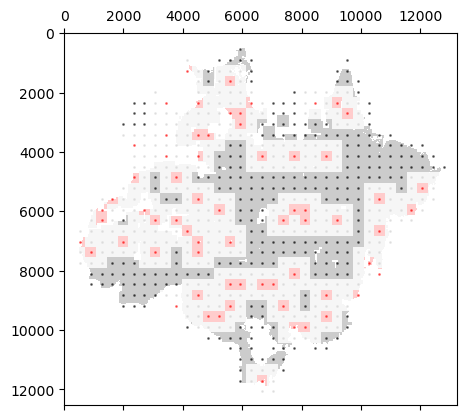

In [58]:
cmap = colors.ListedColormap(['k','red', 'lightgrey'])
cmap.set_under('white')
mat = plt.matshow(split_layer,cmap=cmap,vmin = -.5, vmax = 2.5, alpha=0.2)
plt.scatter(val_data[:,0], val_data[:,1], s=1, c='red', alpha=0.5)
plt.scatter(train_data[:,0], train_data[:,1], s=1, c='k', alpha=0.5)
plt.scatter(dropped_data[:,0], dropped_data[:,1], s=1, c='lightgrey', alpha=0.5)
plt.show()

# Old

In [16]:
train_data_points = get_points_from_cluster(train_data)
val_data_points = get_points_from_cluster(val_data)
dropped_data_points = get_points_from_cluster(dropped_data)
test_data_points = np.concatenate([train_data_points, val_data_points, dropped_data_points])

year = 2015
bio_data_test, _ = load_processed_biomass_data(year, None, resolution=250)
test_data_points_filtered = []
for test_point in test_data_points:
    if include_point(test_point[0],test_point[1],bio_data_test,output_px):
        test_data_points_filtered.append(test_point)
test_data_points = np.array(test_data_points_filtered)

print("train_data: ", len(train_data_points), len(train_data_points)/(len(train_data_points)+len(val_data_points)))
print("val_data: ", len(val_data_points), len(val_data_points)/(len(train_data_points)+len(val_data_points)))
print("test_data: ", len(test_data_points))

train_data:  18572 0.8041219258746103
val_data:  4524 0.19587807412538968
test_data:  53579


In [ ]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data,cmap=cmap,vmin = -.5, vmax = 5.5)
plt.scatter(val_data_points[:,0], val_data_points[:,1], s=0.5, c='orange', alpha=0.2)
plt.scatter(train_data_points[:,0], train_data_points[:,1], s=0.5, c='k', alpha=0.2)
plt.scatter(dropped_data_points[:,0], dropped_data_points[:,1], s=0.5, c='grey', alpha=0.2)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

In [17]:
dtype = np.int16 if np.max(bio_data.shape) <= 32767 else np.int32
torch.save(torch.from_numpy(train_data_points.astype(dtype)), '../data/processed/train_data.pt')
torch.save(torch.from_numpy(val_data_points.astype(dtype)), '../data/processed/val_data.pt')
torch.save(torch.from_numpy(test_data_points.astype(dtype)), '../data/processed/test_data.pt')

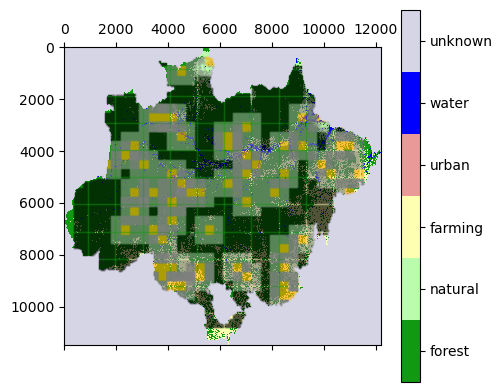

In [18]:
cmap = colors.ListedColormap(['#129912','#bbfcac', '#ffffb2', '#ea9999', '#0000ff', '#D5D5E5'])
mat = plt.matshow(bio_data,cmap=cmap,vmin = -.5, vmax = 5.5)
plt.scatter(val_data_points[:,0], val_data_points[:,1], s=0.5, c='orange', alpha=0.2)
plt.scatter(train_data_points[:,0], train_data_points[:,1], s=0.5, c='k', alpha=0.2)
plt.scatter(dropped_data_points[:,0], dropped_data_points[:,1], s=0.5, c='grey', alpha=0.2)
cax = plt.colorbar(mat, ticks=np.arange(0,6))
cax.ax.set_yticklabels(['forest', 'natural', 'farming', 'urban', 'water', 'unknown'])
plt.show()

# Transision data

In [68]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def transform_crs(dst_crs, resolution):
    for year_start, year_end in zip([2000,2005,2009,2010,2014,2015],[2010,2010,2010,2015,2015,2020]) :
        path_bio = f"../data/raw/biomass/amazonia/{resolution}m/" + f"mapbiomas-brazil-collection-70-amazonia-{year_start}_{year_end}.tif"
        with rasterio.open(path_bio) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(f"../data/interim/biomass/amazonia/{resolution}m/" + f"transition_{year_start}_{year_end}.tif", 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
                
# function to load biomass data
def load_biomass_data(year_start, year_end, shape):
    path_bio = f"../data/interim/biomass/amazonia/{resolution}m/" + f"transition_{year_start}_{year_end}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    return bio_data, out_meta

# function to transform labels to 1=forest, 2=non_forest, 0=unknown
def transform_to_labels(transition_data):
    forest_labels = [1,3,4,5,49]
    deforestation_labels = [14,15,18,19,39,20,40,61,41,36,46,47,48,9,21,
                            22,23,24,30,25]
    transition_labels = []
    for forest_label in forest_labels:
        for deforestation_label in deforestation_labels:
            transition_labels.append(100*forest_label+deforestation_label)
    transition_data_new = np.zeros_like(transition_data, dtype=bool)
    for transition_label in transition_labels:
        transition_data_new[transition_data == transition_label] = True
    return transition_data_new

# function to load biomass data
def load_processed_biomass_data(year_start, year_end, shape, resolution=250):
    path_bio = f"../data/processed/biomass/amazonia/{resolution}m/" 
    path_bio = path_bio + f"transition_{year_start}_{year_end}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255
            transition_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            transition_data = transition_data.squeeze().astype(bool)
            out_meta.update({"driver": "GTiff",
                 "height": transition_data.shape[0],
                 "width": transition_data.shape[1],
                 "transform": out_transform})
        else:
            transition_data = src.read(1).astype(bool)
    return transition_data, out_meta

def preprocess_data(dst_crs, resolution):
    # transform_crs(dst_crs, resolution)

    for year_start, year_end in zip([2000,2005,2009,2010,2014,2015],[2010,2010,2010,2015,2015,2020]):
        transition_data, out_meta = load_biomass_data(year_start, year_end, None)
        transition_data = transform_to_labels(transition_data)
     
        with rasterio.open(f"../data/processed/biomass/amazonia/{resolution}m/" + f"transition_{year_start}_{year_end}.tif", "w", **out_meta) as dest:
            dest.write(np.expand_dims(transition_data, axis=0))

    # missing transition map
    transition_2010_2015, _ = load_processed_biomass_data(2010, 2015, None, resolution=resolution)
    transition_2005_2010, out_meta = load_processed_biomass_data(2010, 2015, None, resolution=resolution)
    transition_2005_2015 = (transition_2010_2015|transition_2005_2010)
    with rasterio.open(f"../data/processed/biomass/amazonia/{resolution}m/" + f"transition_{2005}_{2015}.tif", "w", **out_meta) as dest:
            dest.write(np.expand_dims(transition_2005_2015, axis=0))


In [69]:
resolution = 250
dst_crs = 'EPSG:6933'
preprocess_data(dst_crs, resolution)

# Load transition data

In [70]:
year_start = 2005
year_end = 2015
transition_data, transition_data_meta = load_processed_biomass_data(year_start, year_end, None, resolution=250)

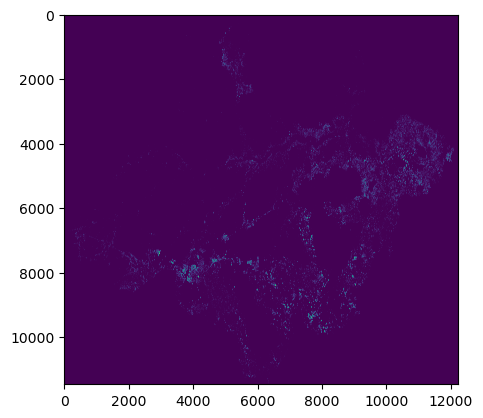

In [71]:
plt.imshow(transition_data)
plt.show()